In [49]:
import configparser
import numpy as np
import time
import xgboost as xgb
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from pycm import ConfusionMatrix

from data_loader import DataLoader
from feature_selector import BaselineSelector, AnalysisSelector
from utils import balanced_split, parse_config_features, shape_wrapper, plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [50]:
def get_model(config: configparser.ConfigParser):
    """
    Returns model by name
    """
    hyperparams = config['Model']
    name = hyperparams['model_name']
    print(name)
    random_state = None if hyperparams['random_state'] == 'None' else int(hyperparams['random_state'])

    if name == 'logistic_regression':
        return LogisticRegression(random_state=random_state)
    
    elif name == 'knn':
        n_neighbors = int(hyperparams['n_neighbors'])
        return KNeighborsClassifier(n_neighbors=n_neighbors)
    
    elif name == 'svm':
        return SVC(random_state=random_state)
    
    elif name == 'random_forest':
        n_estimators = int(hyperparams['n_estimators'])
        max_depth = int(hyperparams['max_depth'])
        return RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    
    elif name == 'xgboost':
        #n_estimators = int(hyperparams['n_estimators'])
        #max_depth = int(hyperparams['max_depth'])
        #eta = float(hyperparams['eta'])
        return xgb.XGBClassifier(learning_rate = 0.1, n_estimators=200, objective='multi:softmax', num_class=2, max_depth = 8, gamma = 0.1,  random_state = random_state)
    
    elif name == 'naive_bayes':
        return GaussianNB()
    
    else:
        raise ValueError(f'Unknown model name: {name}')

In [51]:
def get_metrics(y_true, y_pred):
    """
    Returns metrics for classification
    """
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred, average='macro'),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'confusion_matrix': ConfusionMatrix(y_true, y_pred)
    }

In [52]:
def train_model(config: configparser.ConfigParser):
    """
    Trains model and returns metrics
    """
    X = pd.read_csv(config['Data']['features_path'])

    y = np.loadtxt(config['Data']['labels_path'], dtype=np.int32)

In [53]:
config_path = './config.ini'
config = configparser.ConfigParser()
config.read(config_path)
config['Model']['model_name']

'random_forest'

In [54]:
X = pd.read_csv(config['Data']['features_path'])

y = np.load(config['Data']['labels_path'])
par_ids = np.load(config['Data']['par_ids_path'])
X['par_ids'] = par_ids


In [55]:
X['label'] = y
X = X[X['label'] != 2]
y = X['label']
X = X.drop(['label'], axis=1)

In [56]:
n_folds = int(config['Train']['n_folds'])
num_test_part = int(config['Train']['num_test_part'])


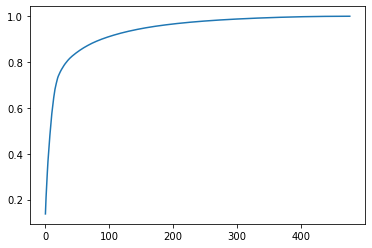

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)
cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative)

In [58]:
y
par_ids = X['par_ids']

In [59]:
dataset_path = config['Data']['dataset_path']
y_test_all = []
y_pred_all = []
for k in range(n_folds):
    model_names = ['random_forest']
    for model_name in model_names:
        
        config.set('Model', 'model_name', model_name)

        train_ids, test_ids = balanced_split(dataset_path, num_test_part)

        X_train = X[X['par_ids'].isin(train_ids)]
        X_test = X[X['par_ids'].isin(test_ids)]

        y_train = y[np.isin(par_ids, train_ids)]
        y_test = list(y[np.isin(par_ids, test_ids)])

        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

        X_train = X_train.drop(['par_ids'], axis=1)
        X_test = X_test.drop(['par_ids'], axis=1)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        #pca = PCA(n_components=180)
        #X_train = pca.fit_transform(X_train)
        #X_test = pca.transform(X_test)
        
        # oversample
        oversample = SMOTE()
        X_train, y_train = oversample.fit_resample(X_train, y_train)

        model = get_model(config)

        print('starting training')
        # train and evaluate model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print('finished training')
        metrics = get_metrics(y_test, y_pred)
        print(metrics)
        y_test_all.append(y_test)
        y_pred_all.append(y_pred)

random_forest
starting training
finished training
{'accuracy': 0.6870243531202436, 'f1': 0.6850609385512735, 'precision': 0.6960235842588784, 'recall': 0.6895290476632048, 'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1])}
random_forest
starting training
finished training
{'accuracy': 0.7708491281273692, 'f1': 0.7706355443342754, 'precision': 0.7708441634327485, 'recall': 0.7705495202201905, 'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1])}
random_forest
starting training
finished training
{'accuracy': 0.7244546498277842, 'f1': 0.7131830513099813, 'precision': 0.7537751677852349, 'recall': 0.719477928717585, 'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1])}
random_forest
starting training
finished training
{'accuracy': 0.720705150362945, 'f1': 0.720030637353977, 'precision': 0.7198722399334527, 'recall': 0.7206216318225376, 'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1])}
random_forest
starting training


KeyboardInterrupt: 

In [ ]:
#make list od lists just one list with all values
y_test_all = [item for sublist in y_test_all for item in sublist]
y_pred_all = [item for sublist in y_pred_all for item in sublist]
metrics = get_metrics(y_test_all, y_pred_all)

{'accuracy': 0.720705150362945, 'f1': 0.720030637353977, 'precision': 0.7198722399334527, 'recall': 0.7206216318225376, 'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1])}


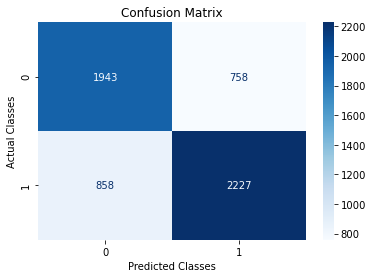

In [60]:
print(metrics)
plot_confusion_matrix(metrics['confusion_matrix'])

In [61]:
y_train = list(y_train)

In [62]:
# metrike za treniranje
y_pred_train = model.predict(X_train)
metrics_train = get_metrics(y_train, y_pred_train)
plot_confusion_matrix(metrics_train['confusion_matrix'])
print(metrics_train)

c:\Users\Zephyrus\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:891: RuntimeWarning: invalid value encountered in true_divide
  proba /= len(self.estimators_)


AttributeError: 'list' object has no attribute 'take'